In [322]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
from sklearn import tree

%matplotlib inline

In [323]:
test = pd.read_csv('/Users/dominicdebiaso/Development/datasets/dsc_abtest_test_table.csv')
user = pd.read_csv('/Users/dominicdebiaso/Development/datasets/dsc_abtest_user_table.csv')

## EDA

In [324]:
# Duplicates in test info?
print(len(test.user_id) == len(test.user_id.unique()))

# Duplicates in the user info?
print(len(user.user_id) == len(user.user_id.unique()))

# Are the users present in both tables?
print(len(test.user_id) - len(user.user_id))

# Merge into large dataset
df = pd.merge(test, user, on='user_id', how='outer')
df['date'] = pd.to_datetime(df.date, errors='coerce')

True
True
454


In [325]:
df.dtypes

user_id                      int64
date                datetime64[ns]
source                      object
device                      object
browser_language            object
ads_channel                 object
browser                     object
conversion                   int64
test                         int64
sex                         object
age                        float64
country                     object
dtype: object

In [326]:
df.describe(include='all').fillna('')

,user_id,date,source,device,browser_language,ads_channel,browser,conversion,test,sex,age,country
count,453321,453321,453321,453321,453321,181877,453321,453321,453321,452867,452867,452867
unique,,5,3,2,3,5,7,,,2,,17
top,,2015-12-04 00:00:00,Ads,Web,ES,Facebook,Android_App,,,M,,Mexico
freq,,141163,181877,251565,377547,68425,155135,,,264485,,128484
first,,2015-11-30 00:00:00,,,,,,,,,,
last,,2015-12-04 00:00:00,,,,,,,,,,
mean,499938,,,,,,,0.0495786,0.476446,,27.1307,
std,288665,,,,,,,0.217073,0.499445,,6.77668,
min,1,,,,,,,0,0,,18,
25%,249816,,,,,,,0,0,,,


In [327]:
df.isnull().sum()

user_id                  0
date                     0
source                   0
device                   0
browser_language         0
ads_channel         271444
browser                  0
conversion               0
test                     0
sex                    454
age                    454
country                454
dtype: int64

In [328]:
# Check conversion per country
df.groupby('country')['conversion'].mean().sort_values(ascending=False)

country
Spain          0.079719
Costa Rica     0.053494
Nicaragua      0.053399
Colombia       0.051332
El Salvador    0.050765
Mexico         0.050341
Peru           0.050258
Chile          0.049704
Venezuela      0.049666
Guatemala      0.049653
Honduras       0.049253
Ecuador        0.049072
Paraguay       0.048863
Bolivia        0.048634
Panama         0.048089
Argentina      0.013994
Uruguay        0.012821
Name: conversion, dtype: float64

In [329]:
# Spain was baseline thus nothing changed so remove it
df_test = df.loc[df.country != 'Spain']

# What was conversion when not in control (1) vs  in control (0)
# H0: sample/population means equal each other, HA: sample/population means differ, reject null of equal averages
# Welcg's t-test used whcih does not assume equal population variance
stats.ttest_ind(df_test.conversion.loc[df_test.test == 1], df_test.conversion.loc[df_test.test == 0], equal_var=False)

Ttest_indResult(statistic=-7.3939374121344805, pvalue=1.4282994754055316e-13)

In [330]:
# Mean not in control
print(df_test.conversion.loc[df_test.test == 1].mean())
# Mean in control
print(df_test.conversion.loc[df_test.test == 0].mean())

0.0434247139821
0.0483304231607


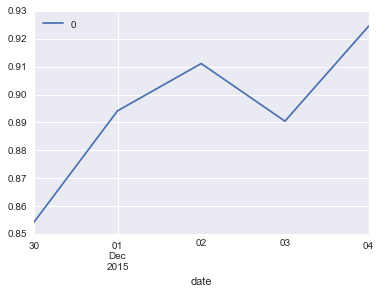

In [331]:
# Find the ratio of converted to non converted
df_test.groupby('date').apply(lambda x: (x.conversion.loc[x.test == 1]).mean() / 
                                        (x.conversion.loc[x.test == 0]).mean()).reset_index().plot(x='date', kind='line')

In [332]:
# Test if users were truly randomly split into test(1) and control(0)
df_model = df_test
df_model['date'] = df_model['date'].astype('object')
df_model = pd.get_dummies(df_model).fillna(0)

# Using decision tree to test if being in test or control has bias
clf_tree = tree.DecisionTreeClassifier(max_depth=2)
clf_tree.fit(df_model.drop(['test', 'conversion'], axis=1), df_model.test)

/Users/dominicdebiaso/Development/virtualenvs/generalenv/lib/python2.7/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            presort=False, random_state=None, splitter='best')

In [333]:
# Multiple ways to view the tree, seem that Argentina and Uruguay are strong predictors for test/control
importances = clf_tree.feature_importances_
importances = zip(df_model.drop(['test', 'conversion'], axis=1).columns, importances)
sorted(importances, key=lambda x: x[1], reverse=True)[:3]

# zip(df_model.drop(['test', 'conversion'], axis=1).columns[clf_tree.tree_.feature], 
#     clf_tree.tree_.threshold, clf_tree.tree_.children_left, clf_tree.tree_.children_right)

# from sklearn.externals.six import StringIO
# import pydotplus
# from IPython.display import Image
# dot_data = StringIO()
# tree.export_graphviz(clf, out_file=dot_data, 
#                      feature_names=df_model.drop(['test', 'conversion'], axis=1).columns, class_names='test', 
#                      filled=True, rounded=True, 
#                      special_characters=True)
# graph=pydotplus.graph_from_dot_data(dot_data.getvalue())
# Image(graph.create_png())

[('country_Argentina', 0.84650090114422283),
 ('country_Uruguay', 0.15321392730013658),
 ('user_id', 0.00028517155564066057)]

In [340]:
# Check t-test for each country; test is clearly not significant
# df_test.groupby('country').size()
df_test.groupby('country').apply(lambda x: stats.ttest_ind(
        (x.conversion.loc[x.test == 1]), (x.conversion.loc[x.test == 0]))[1]).sort_values()

country
Mexico         0.165547
El Salvador    0.248251
Chile          0.302871
Argentina      0.321766
Colombia       0.423733
Honduras       0.471721
Guatemala      0.572165
Venezuela      0.573740
Costa Rica     0.687863
Panama         0.705361
Bolivia        0.718877
Peru           0.771950
Nicaragua      0.780351
Uruguay        0.882812
Paraguay       0.883702
Ecuador        0.961512
dtype: float64